In [1]:
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

Function: $$f(x) = (Ddiag(Bx)D^T)^{-1}w$$
Let $$M(x) = D \cdot diag(Bx) \cdot D^T$$
then $$f(x) = M(x)^{-1}w$$
$$w = f(x)M(x)$$

$$\nabla[Ddiag(Bx) D^T f(x)] = 0$$

Product rule:
$$\nabla_{x_1}[D\text{diag}(Bx_1)D^Tf(x)] + \nabla_{x_2}[D\text{diag}(Bx)D^Tf(x_2)] = 0$$

$$\nabla_{x1}[(Bx_1) \odot (D^Tf(x))]D^T + \nabla_{x2}f(x)[D\text{diag}(Bx)D^T]= 0$$

Move $f(x)$ to one side

$$\nabla f(x)[D\text{diag}(Bx)D^T] = -\nabla_{x1}[(Bx_1) \odot (D^Tf(x))]D^T$$

Solve $\nabla_{x1}$
$$\nabla_{x1}[(Bx_1) \odot (D^Tf(x))] = B^T\text{diag}(D^Tf(x))$$

Solve for $\nabla f(x)$
$$\nabla f(x)[D\text{diag}(Bx)D^T] = -B^T\text{diag}(D^Tf(x))D^T$$

$$\nabla f(x) = -B^T\text{diag}(D^Tf(x))D^T(D\text{diag}(Bx)D^T)^{-1}$$




Notes: f(x) is dimension m,1 \\
B is dimension m,n \\
x is dimension n,1 \\
Bx is dim m,1 \\
D is m,m





In [2]:
# function
def f(x):
  dim = x.shape[0]
  assert x.shape == (dim, 1) # ensuring input is valid in context

  Bx = (B@x).squeeze()

  diag_part = torch.diag(Bx)

  inner = D @ diag_part @ D.T

  return torch.linalg.inv(inner) @ w

#gradient
def grad_f(x):
  # compute Bx
  Bx = (B@x).squeeze()

  # diag(Bx)
  diag_Bx = torch.diag(Bx)

  # D * diag(Bx) * D^T
  D_diag_Bx_Dt = D @ diag_Bx @ D.T

  # inverse of D * diag(Bx) * D^T
  D_diag_Bx_Dt_inv = torch.inverse(D_diag_Bx_Dt)

  # compute D^T * f(x)
  Dt_fx = D.T @ f(x)

  # diag(D^T * f(x))
  diag_Dt_fx = torch.diag(Dt_fx.squeeze())

  # final gradient calculation
  gradient = -B.T @ diag_Dt_fx @ D.T @ D_diag_Bx_Dt_inv

  return gradient

#gradient using AD
def grad_f_AD(x):
  x.requires_grad = True
  y = f(x)

  dy = torch.zeros(n,m)


  # for loop through identity matrix to compute derivates
  for i in range(m):
    grad_output = torch.zeros(m,1)
    grad_output[i] = 1
    row = torch.autograd.grad(outputs = y, inputs = x, grad_outputs = grad_output, create_graph=True)[0]

    dy[:,i] = row[:,0]

  x = x.detach()
  y = y.detach()
  return dy.detach()



In [3]:
m = 15
n = 10
D = torch.randn(m,m)
B = torch.randn(m,n)
w = torch.randn(m,1)

In [6]:
dim = n
x = torch.randn(dim,1)
v = torch.randn_like(x)
v = v / torch.norm(v)

max_iters = 32
h = torch.zeros(max_iters)
err0 = torch.zeros(max_iters) # error from zero order T.P.
err1 = torch.zeros(max_iters) # error from first order T.P.

for i in range(max_iters):
  h[i] = 2**(-i) # iterate h down

  #regular way
  fv = f(x + h[i]*v)
  T0 = f(x)
  T1 = T0 + h[i] * (grad_f(x)).T @ v

  #using AD
  # fv = f(x+h[i]*v).detach()
  # T0 = f(x).detach()
  # T1 = T0 + h[i] * (grad_f_AD(x)).T @ v

  err0[i] = torch.norm(fv - T0)
  err1[i] = torch.norm(fv - T1)

  print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

h: 1.000e+00, 	 err0: 3.633e+00, 	 err1: 5.069e+01
h: 5.000e-01, 	 err0: 4.579e+00, 	 err1: 2.803e+01
h: 2.500e-01, 	 err0: 7.058e+00, 	 err1: 1.876e+01
h: 1.250e-01, 	 err0: 3.972e+01, 	 err1: 4.557e+01
h: 6.250e-02, 	 err0: 5.948e+00, 	 err1: 3.012e+00
h: 3.125e-02, 	 err0: 1.918e+00, 	 err1: 4.452e-01
h: 1.562e-02, 	 err0: 8.297e-01, 	 err1: 9.136e-02
h: 7.812e-03, 	 err0: 3.906e-01, 	 err1: 2.089e-02
h: 3.906e-03, 	 err0: 1.900e-01, 	 err1: 5.005e-03
h: 1.953e-03, 	 err0: 9.379e-02, 	 err1: 1.225e-03
h: 9.766e-04, 	 err0: 4.659e-02, 	 err1: 3.032e-04
h: 4.883e-04, 	 err0: 2.322e-02, 	 err1: 7.540e-05
h: 2.441e-04, 	 err0: 1.159e-02, 	 err1: 1.880e-05
h: 1.221e-04, 	 err0: 5.792e-03, 	 err1: 4.694e-06
h: 6.104e-05, 	 err0: 2.895e-03, 	 err1: 1.173e-06
h: 3.052e-05, 	 err0: 1.447e-03, 	 err1: 2.931e-07
h: 1.526e-05, 	 err0: 7.236e-04, 	 err1: 7.327e-08
h: 7.629e-06, 	 err0: 3.618e-04, 	 err1: 1.831e-08
h: 3.815e-06, 	 err0: 1.809e-04, 	 err1: 4.578e-09
h: 1.907e-06, 	 err0: 9.044e-05

(array([1.e-17, 1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03,
        1.e-01, 1.e+01, 1.e+03, 1.e+05]),
 [Text(0, 1e-17, '$\\mathdefault{10^{-17}}$'),
  Text(0, 1e-15, '$\\mathdefault{10^{-15}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$'),
  Text(0, 1e-11, '$\\mathdefault{10^{-11}}$'),
  Text(0, 1e-09, '$\\mathdefault{10^{-9}}$'),
  Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$')])

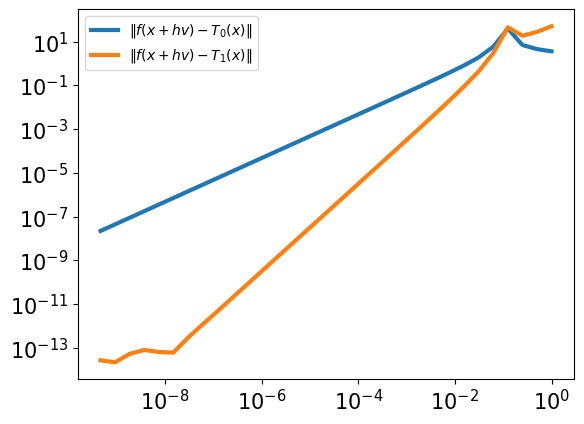

In [7]:
plt.loglog(h, err0, linewidth = 3)
plt.loglog(h, err1, linewidth = 3)
plt.legend(['$\|f(x+hv) - T_0(x)\|$', '$\|f(x+hv) - T_1(x)\|$'])
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)